In [1]:
# import library
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import Tensor
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import pandas as pd
import japanize_matplotlib

In [2]:
version = '06-3'
model_dir = './model/' + version
data_path = f'data/eq05-3.txt'
test_data_path = f'data/eq05-3-test.txt'



## 初期設定

### データセット定義

In [3]:

# 事前設定
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model_dir_path = Path(model_dir)

def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



Using device: cuda:0


In [4]:
src_data, tgt_data = read_file(data_path)
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)
reverse_vocab = {idx: token for token, idx in vocab_tgt.items()}

PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

### モデル定義

In [5]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [6]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)


    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        #Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        return tgt

class TransformerEncoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerEncoderLayerScratch, self).__init__()
        # Self-attention for the encoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention
        memory, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        memory = src + self.dropout1(memory)
        memory = self.norm1(memory)
        
        return memory


class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        self.encoder_layer = TransformerEncoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )

        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        memory = self.encoder_layer(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs/math.sqrt(self.token_embedding.embedding_size), self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)
    

def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [7]:


#loaded_model用のSeq2Seqクラス
class Seq2SeqForSavedModel(Seq2SeqTransformer):
    def __init__(self, *args, **kwargs):
        super(Seq2SeqForSavedModel, self).__init__(*args, **kwargs)
        self.pca = None

    def positional_encoding(self, tensor: Tensor, maxlen=5000):
        embedding_size = tensor.size(-1)
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)
        return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)
    
    def self_attn_decoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.decoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.decoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.decoder_layer.self_attn.out_proj.weight.data.T) + self.decoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights

    def self_attn_encoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.encoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.encoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.encoder_layer.self_attn.out_proj.weight.data.T) + self.encoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights
    
    def cross_attn(self, tgt, memory, embedding_size):
        multi_attn_wq, multi_attn_wk, multi_attn_wv = self.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = self.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
        KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(multi_attn_weights, VW)
        multi_attn_output = torch.matmul(AV, self.decoder_layer.cross_attn.out_proj.weight.data.T) + self.decoder_layer.cross_attn.out_proj.bias.data
        return tgt + multi_attn_output.permute(1, 0, 2), multi_attn_output.permute(1, 0, 2), multi_attn_weights

    def predict_next_token(self, src, tgt, embedding_size, device=device):
        memory = self.positional_encoding(self.token_embedding(src))
        tgt_embed = self.positional_encoding(self.token_embedding(tgt))
        tgt_mask = generate_square_subsequent_mask(tgt.size(0)).to(device).type(torch.bool)

        memory, _, _ = self.self_attn_encoder(memory, embedding_size)
        memory = self.encoder_layer.norm1(memory)
        # memory = self.encoder_layer.norm2(F.relu(self.encoder_layer.linear1(memory)) + memory)

        tgt, _, self_attn_weights = self.self_attn_decoder(tgt_embed, embedding_size)
        tgt = self.decoder_layer.norm1(tgt)
        tgt, _, multi_attn_weights = self.cross_attn(tgt, memory, embedding_size)
        tgt = self.decoder_layer.norm2(tgt)
        # tgt = self.decoder_layer.norm3(F.relu(self.decoder_layer.linear1(tgt)) + tgt)
        output = self.compute_output(tgt.transpose(0, 1)[:, -1])

        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        return next_word, self_attn_weights, multi_attn_weights
    


In [8]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 16
nhead = 1
dim_feedforward = 16
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')

loaded_model = Seq2SeqForSavedModel(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqForSavedModel(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 16, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inpla


## Attentionの図示

Attentionがうまく言っている例

In [9]:

def plot_heatmap(attention_map, src_label=[], ys_label=[], title="Attention Map"):
    # ヒートマップとしてAttentionを描画
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_map, annot=False, cmap='viridis', cbar=True)
    plt.title(title)
    xticks = [f"{src_label[i]}" for i in range(len(src_label))]
    yticks = [f"{ys_label[i]}" for i in range(len(ys_label))]
    plt.xticks(ticks=np.arange(len(src_label))+0.5, labels=xticks, rotation=0)
    plt.yticks(ticks=np.arange(len(ys_label))+0.5, labels=yticks, rotation=0)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.show()

In [10]:
import random

# 0番目のデータで分離
nth_token = 1

def read_file(file_path):
    with open(file_path, 'r') as file:
        return [tuple(line.strip().split(' => ')) for line in file.readlines()]

test_data = read_file(test_data_path)
test_data = list(set(test_data))
# test_dataの文字数が5以上のデータを取得
test_data_src = [data[0] for data in test_data if len(data[0]) >= 5]
test_data_answer = [data[1] for data in test_data if len(data[0]) >= 5]
test_data_answer_token = [data[1][nth_token] for data in test_data if len(data[0]) >= 5]
test_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in test_data_src]
# test_data_src = [data[0] for data in test_data if len(data[0]) >= 3]
# test_data_answer_token = [data[1][nth_token] for data in test_data if len(data[0]) >= 3]
# test_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in test_data_src]


# 確認
print("Examples of raw data", test_data[:10])
print("Examples of test data", test_data_src[:10])
print("Examples of answer", test_data_answer[:10])
print("Examples of answer", test_data_answer_token[:10])
print("Data length", len(test_data_src))
print("max length", max([len(x) for x in test_data_src]))

# 1個目の出力までを取得
text = test_data[0]

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

print(ys)


Examples of raw data [('0*0*0+0*0', '+*0*00*00'), ('0*1+1*0', '+*01*10'), ('1*0+0+0+0*0*1', '+*10+0+0*0*01'), ('1*1*0*0+1*1', '+*1*1*00*11'), ('1+1+1*1+0', '+1+1+*110'), ('1*0+1*0*1*0+0*1', '+*10+*1*0*10*01'), ('0+1+1*1*0*1', '+0+1*1*1*01'), ('1*0*1+0', '+*1*010'), ('0*1*0+0+0+0*0', '+*0*10+0+0*00'), ('0+1*1+0*1*1+1', '+0+*11+*0*111')]
Examples of test data ['0*0*0+0*0', '0*1+1*0', '1*0+0+0+0*0*1', '1*1*0*0+1*1', '1+1+1*1+0', '1*0+1*0*1*0+0*1', '0+1+1*1*0*1', '1*0*1+0', '0*1*0+0+0+0*0', '0+1*1+0*1*1+1']
Examples of answer ['+*0*00*00', '+*01*10', '+*10+0+0*0*01', '+*1*1*00*11', '+1+1+*110', '+*10+*1*0*10*01', '+0+1*1*1*01', '+*1*010', '+*0*10+0+0*00', '+0+*11+*0*111']
Examples of answer ['*', '*', '*', '*', '1', '*', '0', '*', '*', '0']
Data length 1040
max length 15
tensor([[12]], device='cuda:0')


torch.Size([15])
('0+1*1+0*1*1+1', '+0+*11+*0*111')


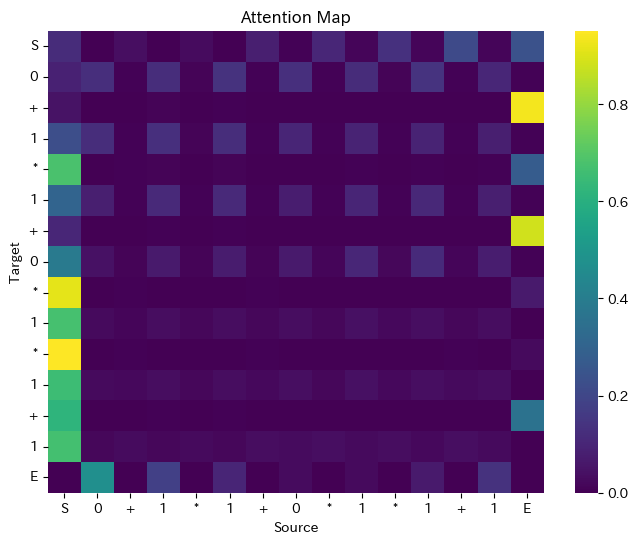

In [11]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, attn_map = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        attn_map = attn_map.squeeze().detach().cpu().numpy()
        vectors.append(attn_map)
        # vectors.append(np.pad(attn_map, [(0, 0), (0, 20-attn_map.shape[1])]))
    vectors_array = np.array(vectors)
    return vectors_array

tgt_index = 9
print(test_src[tgt_index].shape)
print(test_data[tgt_index])

test_vectors = extract_vectors([test_src[tgt_index]], nth_token, loaded_model)[0, :, :]
plot_heatmap(test_vectors, ["S"]+list(test_data_src[tgt_index])+["E"], ["S"]+list(test_data_src[tgt_index])+["E"], title="Attention Map")


In [12]:
for i, x in enumerate(test_data_src):
    if x == "0*0+1+0*0*1*0":
        print(x)
        print(i)

0*0+1+0*0*1*0
988


In [13]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt = ys
        for _ in range(nth_token):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt, embedding_size=embedding_size)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)

        tgt = model.positional_encoding(model.token_embedding(tgt))
        
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)
        tgt, _, attn_map = model.cross_attn(tgt, memory, embedding_size)
        # tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        attn_map = attn_map.squeeze().detach().cpu().numpy()
        vectors.append(np.pad(attn_map, [(0, 0), (0, 20-attn_map.shape[1])]))
        # vectors.append(np.pad(attn_map, [0, 20-len(attn_map)]))
    vectors_array = np.array(vectors)
    return vectors_array

nth_token=5
test_vectors = extract_vectors(test_src, nth_token, loaded_model)


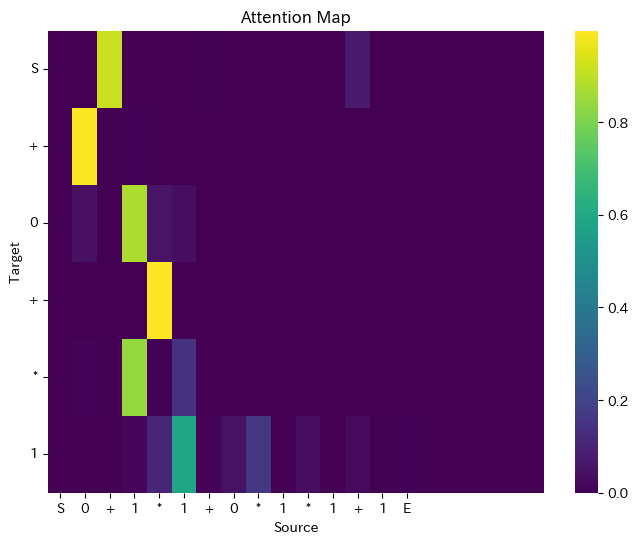

In [14]:
tgt_index = 9
plot_heatmap(test_vectors[tgt_index], ["S"]+list(test_data_src[tgt_index])+["E"], "S"+test_data_answer[tgt_index][:nth_token], title="Attention Map")


('0*1+1*0*1*0+1*0', '+*01+*1*0*10*10')


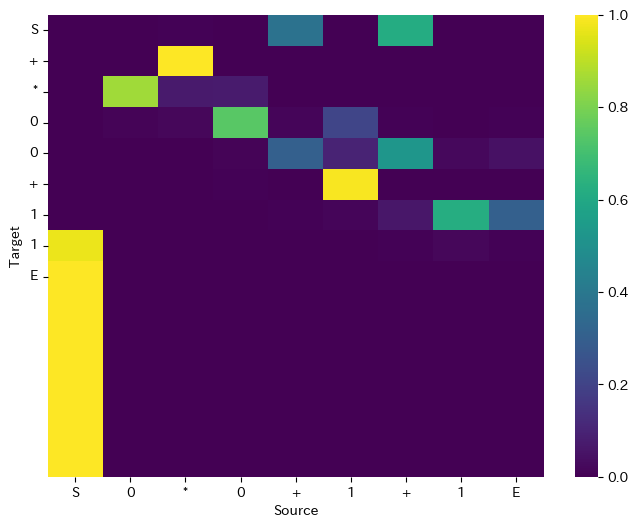

In [15]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt_tmp = ys
        for _ in range(nth_token):
            tgt_embed = model.positional_encoding(model.token_embedding(tgt_tmp))
            tgt, _, self_attn_weights = model.self_attn_decoder(tgt_embed, embedding_size)
            tgt = model.decoder_layer.norm1(tgt)
            tgt, _, multi_attn_weights = model.cross_attn(tgt, memory, embedding_size)
            tgt = model.decoder_layer.norm2(tgt)
            # tgt = self.decoder_layer.norm3(F.relu(self.decoder_layer.linear1(tgt)) + tgt)
            output = model.compute_output(tgt.transpose(0, 1)[:, -1])

            _, next_word = torch.max(output, dim=1)
            next_token = next_word.item()

            tgt_tmp = torch.cat([tgt_tmp, torch.tensor([[next_token]], device=device)], dim=0)

            attn_map = multi_attn_weights.detach().cpu().numpy()
            vectors.append(attn_map[:, -1, :])

    vectors_array = np.array(vectors)
    return vectors_array

tgt_index = 905
nth_token=15
print(test_data[tgt_index])
test_vectors = extract_vectors([test_src[tgt_index]], nth_token, loaded_model).squeeze()
plot_heatmap(test_vectors, ["S"]+list(test_data_src[tgt_index])+["E"], "S"+test_data_answer[tgt_index][:nth_token-1]+"E", title="")

# ベクトルクラスタリング

In [16]:
import random

# 0番目のデータで分離
nth_token = 1

def read_file(file_path):
    with open(file_path, 'r') as file:
        return [tuple(line.strip().split(' => ')) for line in file.readlines()]

test_data = read_file(test_data_path)
test_data = sorted(list(set(test_data)))
# test_dataの文字数が5以上のデータを取得
test_data_src = [data[0] for data in test_data if len(data[0]) == 5]
test_data_answer = [data[1] for data in test_data if len(data[0]) == 5]
test_data_answer_token = [data[1][nth_token] for data in test_data if len(data[0]) == 5]
test_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in test_data_src]


# 確認
print("Examples of raw data", test_data[:10])
print("Examples of test data", test_data_src[:10])
print("Examples of answer", test_data_answer[:10])
print("Examples of answer", test_data_answer_token[:10])
print("Data length", len(test_data_src))
print("max length", max([len(x) for x in test_data_src]))

# 1個目の出力までを取得
text = test_data[0]

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

print(ys)


Examples of raw data [('0', '0'), ('0*0', '*00'), ('0*0*0', '*0*00'), ('0*0*0*0', '*0*0*00'), ('0*0*0*0*0', '*0*0*0*00'), ('0*0*0*0*0+1*1+0', '+*0*0*0*00+*110'), ('0*0*0*0*1', '*0*0*0*01'), ('0*0*0*0*1*0*0+0', '+*0*0*0*0*1*000'), ('0*0*0*0*1+1+0*0', '+*0*0*0*01+1*00'), ('0*0*0*0+0+0+0+0', '+*0*0*00+0+0+00')]
Examples of test data ['0*0*0', '0*0*1', '0*0+0', '0*0+1', '0*1*0', '0*1*1', '0*1+0', '0*1+1', '0+0*0', '0+0*1']
Examples of answer ['*0*00', '*0*01', '+*000', '+*001', '*0*10', '*0*11', '+*010', '+*011', '+0*00', '+0*01']
Examples of answer ['0', '0', '*', '*', '0', '0', '*', '*', '0', '0']
Data length 32
max length 5
tensor([[12]], device='cuda:0')


In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage


from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.cluster.hierarchy import fcluster, linkage

def plot_dendrogram(linkage_matrix, labels, method='ward', metric='euclidean', y_log_limits=(1e-2, 1e2), threshold=None):
    # labels = [x if i%10==0 else "" for i, x in enumerate(test_data_src) ]
    

    # デンドログラムを描画
    plt.figure(figsize=(14, 8))
    dendrogram(
        linkage_matrix,
        leaf_rotation=90,
        leaf_font_size=10,
        labels=labels  # ラベルとしてlabelsを使用
    )

    plt.title("")
    plt.xlabel("labels")
    plt.ylabel("Distance")
    plt.ylim(y_log_limits)
    plt.yscale('log')
    if threshold is not None:
        plt.axhline(y=threshold, color='k', linewidth=1, linestyle='dashed')

    plt.show()
    return

def visualize_hierarchical_clustering_silhouette(data, labels, max_clusters=20, method='ward', metric='euclidean'):
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    linkage_matrix = linkage(data, method=method, metric=metric)
    plot_dendrogram(linkage_matrix, labels, method=method, metric=metric)
    # optimal_clusters = plot_silhouette_scores(data, linkage_matrix, max_clusters=max_clusters)
    # plot_silhouette_plot(data, linkage_matrix, clusters_to_plot=[2, 5, optimal_clusters])
    # cluster_labels = fcluster(linkage_matrix, t=optimal_clusters, criterion='maxclust')
    # return linkage_matrix, cluster_labels
    return linkage_matrix


(32, 5, 16)


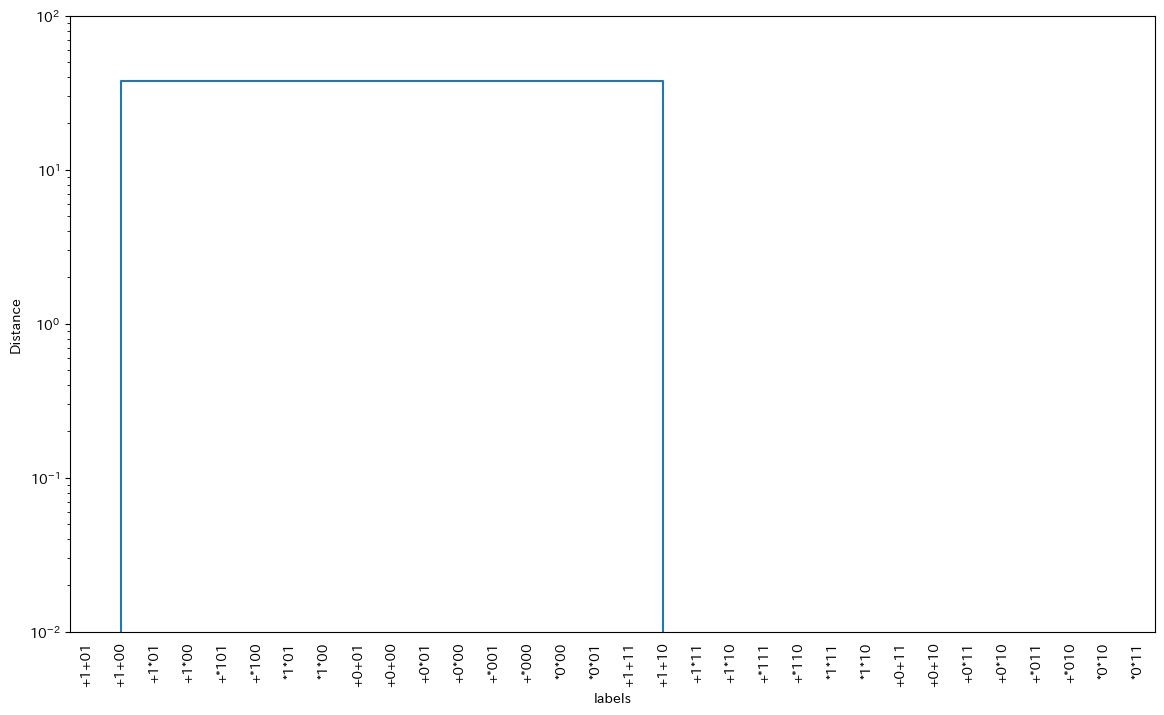

In [18]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        # memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        # memory = model.encoder_layer.norm1(memory)
        
        # tgt = ys
        # for _ in range(nth_token):
        #     next_token, _, _ = loaded_model.predict_next_token(src, tgt)
        #     tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)


        # tgt = model.positional_encoding(model.token_embedding(ys))
        
        # tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        # tgt = model.decoder_layer.norm1(tgt)
        # tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        # tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(memory.detach().cpu().numpy().squeeze()[:5, :])
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, nth_token, loaded_model)

print(test_vectors.shape)

linkage_matrix = visualize_hierarchical_clustering_silhouette(test_vectors[:, 3, :], test_data_answer)


(32, 5, 16)


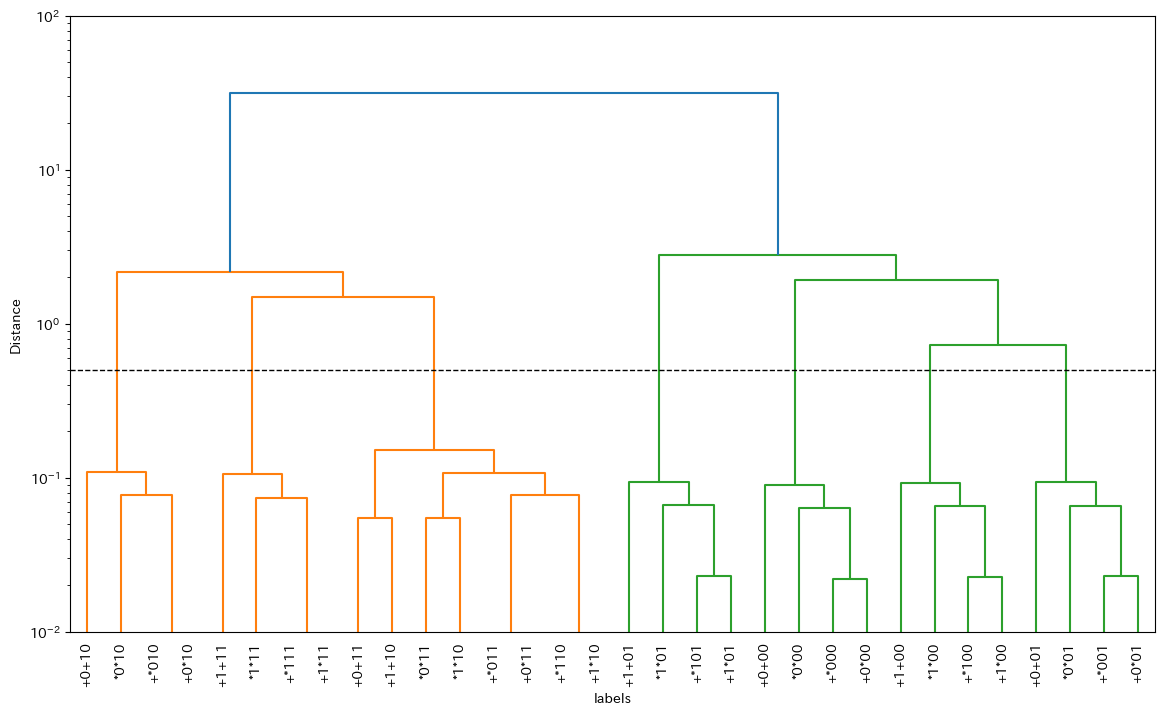

In [19]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        # tgt = ys
        # for _ in range(nth_token):
        #     next_token, _, _ = loaded_model.predict_next_token(src, tgt)
        #     tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)


        # tgt = model.positional_encoding(model.token_embedding(ys))
        
        # tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        # tgt = model.decoder_layer.norm1(tgt)
        # tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        # tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(memory.detach().cpu().numpy().squeeze()[:5, :])
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, nth_token, loaded_model)

print(test_vectors.shape)

linkage_matrix = linkage(test_vectors[:, 3, :], method="ward", metric="euclidean")
plot_dendrogram(linkage_matrix, test_data_answer, method="ward", metric="euclidean", y_log_limits=(1e-2, 1e2), threshold=0.5)


In [20]:

def display_samples_by_cluster(data, linkage_matrix, n_clusters, num_samples=10):
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        print(f"\nCluster {cluster}:\n" + "-"*20)
        # 指定されたクラスタに属するデータを取得
        cluster_data = [data[i] for i in range(len(data)) if cluster_labels[i] == cluster]
        cluster_data = list(set(cluster_data))
        # 最大 num_samples 件のデータを表示
        for sample in cluster_data[:num_samples]:
            print(sample)

display_samples_by_cluster(test_data_src, linkage_matrix, n_clusters=7, num_samples=10)


Cluster 1:
--------------------
0+1*0
0+1+0
0*1*0
0*1+0

Cluster 2:
--------------------
1*1+1
1+1+1
1*1*1
1+1*1

Cluster 3:
--------------------
0+1+1
1*1*0
1+1+0
0*1*1
1+1*0
1*1+0
0+1*1
0*1+1

Cluster 4:
--------------------
1+0*1
1*0*1
1*0+1
1+0+1

Cluster 5:
--------------------
0*0+0
0*0*0
0+0*0
0+0+0

Cluster 6:
--------------------
1*0*0
1+0*0
1*0+0
1+0+0

Cluster 7:
--------------------
0+0+1
0*0+1
0*0*1
0+0*1


In [21]:
display_samples_by_cluster(test_data_answer, linkage_matrix, n_clusters=7, num_samples=10)


Cluster 1:
--------------------
+*010
+0*10
*0*10
+0+10

Cluster 2:
--------------------
+1+11
*1*11
+*111
+1*11

Cluster 3:
--------------------
*1*10
*0*11
+0+11
+*011
+0*11
+1*10
+1+10
+*110

Cluster 4:
--------------------
+1+01
*1*01
+1*01
+*101

Cluster 5:
--------------------
+0+00
+0*00
*0*00
+*000

Cluster 6:
--------------------
+*100
+1+00
+1*00
*1*00

Cluster 7:
--------------------
+0*01
+*001
+0+01
*0*01


(32, 16)


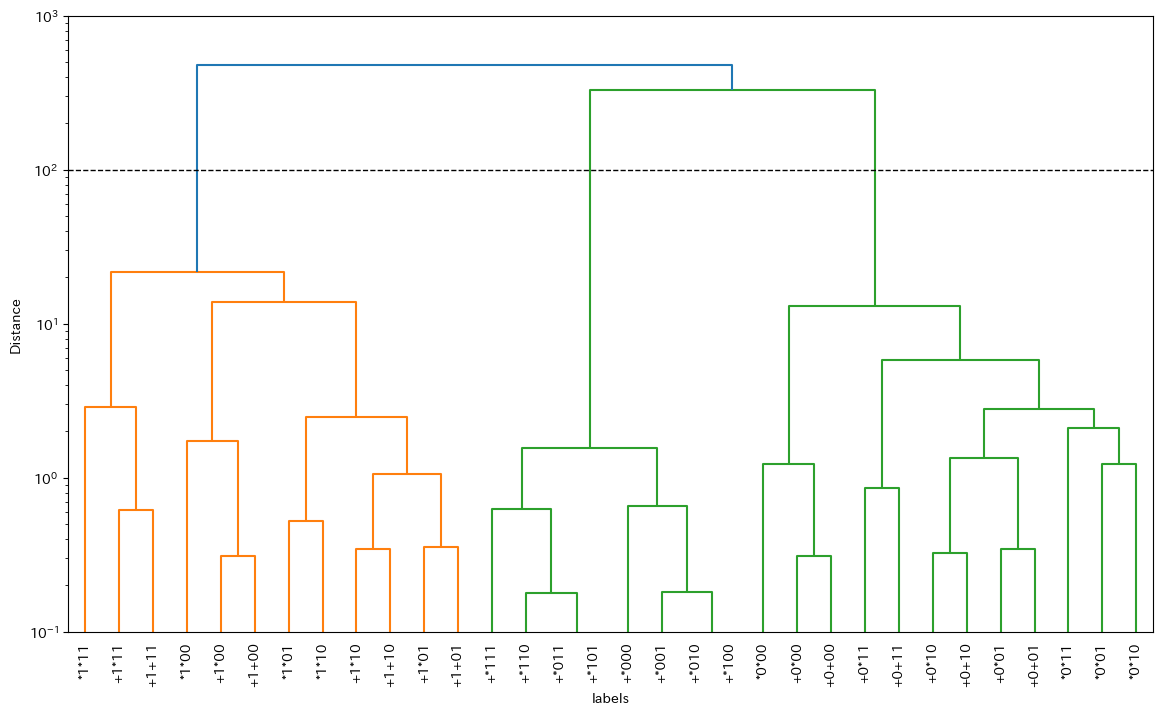


Cluster 1:
--------------------
1*1*0
1+1+0
1+0*1
1+1+1
1*1*1
1+1*0
1*0*1
1+0+0
1*0*0
1+0*0

Cluster 2:
--------------------
1*0+1
0*0+1
0*1+0
1*0+0
1*1+0
1*1+1
0*0+0
0*1+1

Cluster 3:
--------------------
0+1+1
0+1*0
0+0*0
0+0*1
0+0+0
0*1*1
0*1*0
0*0*1
0*0*0
0+1*1

Cluster 1:
--------------------
*1*10
+1+11
+1*00
+1*11
*1*01
*1*11
+1+01
+1*10
+1+00
+1+10

Cluster 2:
--------------------
+*010
+*000
+*111
+*001
+*011
+*101
+*100
+*110

Cluster 3:
--------------------
+0*00
+0+00
+0*10
*0*01
*0*10
*0*11
+0+10
+0+01
+0*11
*0*00


In [22]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt = ys
        for _ in range(nth_token):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt, embedding_size=embedding_size)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)

        tgt = model.positional_encoding(model.token_embedding(tgt))
        
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)
        tgt, tgt_, _ = model.cross_attn(tgt, memory, embedding_size)
        # tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(tgt_.detach().cpu().numpy().squeeze()[-1, :])
        # vectors.append(tgt_.detach().cpu().numpy().squeeze()[:5, :])
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, nth_token, loaded_model)

print(test_vectors.shape)

linkage_matrix = linkage(test_vectors, method="ward", metric="euclidean")
plot_dendrogram(linkage_matrix, test_data_answer, method="ward", metric="euclidean", y_log_limits=(1e-1, 1e3), threshold=100)
# linkage_matrix = visualize_hierarchical_clustering_silhouette(test_vectors[:, :], test_data_answer)
display_samples_by_cluster(test_data_src, linkage_matrix, n_clusters=3, num_samples=10)

display_samples_by_cluster(test_data_answer, linkage_matrix, n_clusters=3, num_samples=10)



(32, 16)


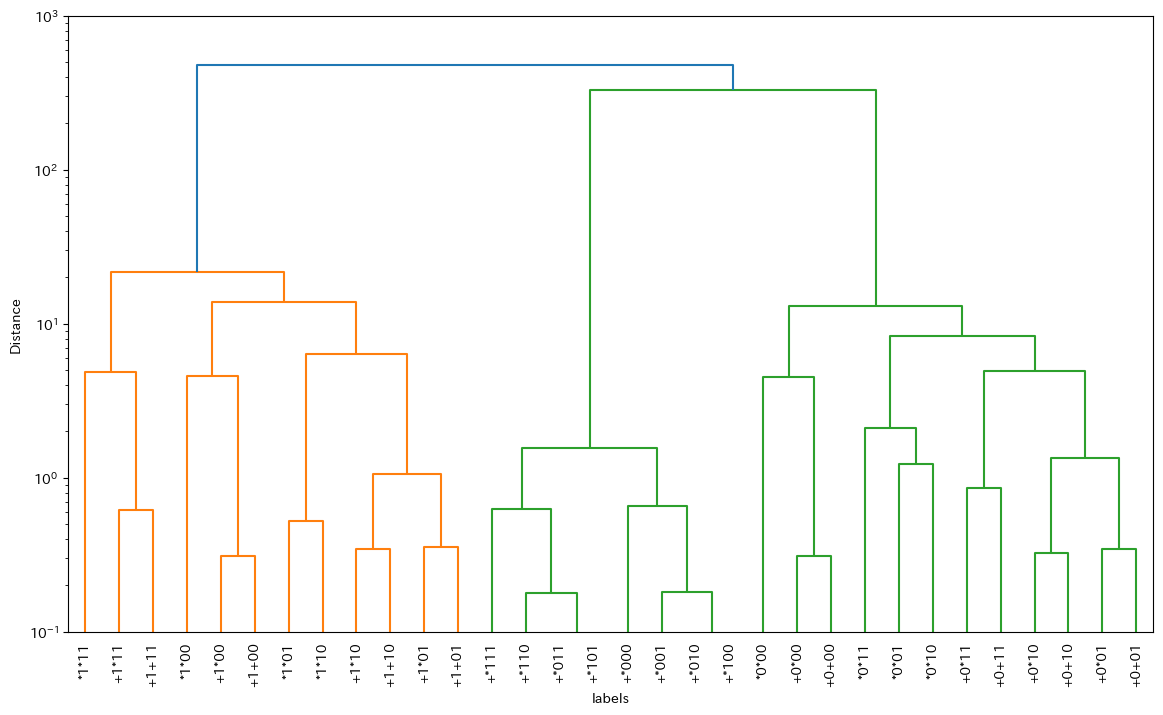

In [23]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt = ys
        for _ in range(nth_token):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt, embedding_size=embedding_size)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)

        tgt = model.positional_encoding(model.token_embedding(tgt))
        
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)
        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        # tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(tgt.detach().cpu().numpy().squeeze()[-1, :])
        # vectors.append(tgt_.detach().cpu().numpy().squeeze()[:5, :])
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, 1, loaded_model)

print(test_vectors.shape)

linkage_matrix = linkage(test_vectors, method="ward", metric="euclidean")
plot_dendrogram(linkage_matrix, test_data_answer, method="ward", metric="euclidean", y_log_limits=(1e-1, 1e3))
# linkage_matrix = visualize_hierarchical_clustering_silhouette(test_vectors[:, :], test_data_answer)

